In [147]:
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab import drive
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1 - INPUT DATA

In [148]:
# Physical Data
L = 1.0  #m
H = 1.0  #m
P_in = 101325  #Pa
T_in = 293  #K
V_in = 5.15  #m/s
Rho_in = P_in / (287*T_in)  #kg/m^3

# Numeral Data
N = 200
M = 200
rho_gamma = 10  # there will be 4 different cases: 10, 100, 1000 and 10E7
gamma = Rho_in/rho_gamma
phi_high = 1.0
phi_low  = 0.0
dt = 0.1  # time step
delta = 0.000001  # accuracy
delta_N = L/N
delta_M = H/M
t_max     = 1000000                        # G-S loop steps.
time_max  = 1000000                        # Time loop steps.

MESH

In [149]:
# Control Volumes
X_cv = np.linspace(0, L, N+1)
Y_cv = np.linspace(0, H, M+1)

#print(X_cv)
# Mesh Generation
X_P  = np.zeros(N+2)
Y_P  = np.zeros(M+2)

for i in range(1, N+1):
    X_P[i] = (X_cv[i-1] + X_cv[i])/2

for j in range(1, M+1):
    Y_P[j] = (Y_cv[j-1] + Y_cv[j])/2

X_P[0] = X_cv[0]
X_P[-1] = X_cv[-1]
Y_P[0] = Y_cv[0]
Y_P[-1] = Y_cv[-1]

#print(X_P)
# Velocity Field
Vx = np.zeros((M+2, N+2))
Vy = np.zeros((M+2, N+2))
for i in range(N+2):
  for j in range(M+2):
    Vx[j][i] = V_in * np.cos(np.pi / 4.0)
    Vy[j][i] = V_in * np.sin(np.pi / 4.0)
#print(Vx)
#print(Vy)
# Define Metrics
a_E = np.zeros((M+2,N+2))
a_W = np.zeros((M+2,N+2))
a_S = np.zeros((M+2,N+2))
a_N = np.zeros((M+2,N+2))
b_P = np.zeros((M+2,N+2))
a_P = np.zeros((M+2,N+2))
m_e = 0.0
m_s = 0.0
m_w = 0.0
m_n = 0.0
D_e = 0.0
D_w = 0.0
D_n = 0.0
D_s = 0.0
phi = np.zeros((M+2,N+2))
phi0 = np.zeros((M+2,N+2))
phi_aux = np.zeros((M+2,N+2))

INITIAL MAP

In [150]:
# Internal nodes
for i in range(1, N+1):
    for j in range(1, M+1):
        phi0[j][i] = 10.0
        phi[j][i] = 10.0

# Walls
for i in range(N+2):
    for j in range(M+2):
        phi0[j][0]  = phi_high
        phi0[-1][i] = phi_high
        phi0[j][-1] = phi_low
        phi0[0][i] = phi_low
        phi[j][0]  = phi_high
        phi[-1][i] = phi_high
        phi[j][-1] = phi_low
        phi[0][i] = phi_low

PREVIOUS CALCULATIONS

In [151]:
def scheme(type, Pe):
  if type == 0:
    return 1
  if type == 1:
    return np.abs(Pe)/(np.exp(np.abs(Pe))-1)

# Internal nodes
type = 1 ################################# 0 --> upwind & 1 --> Exponential

for i in range(1, N+1):
  for j in range(1, M+1):
      De = (gamma*delta_M)/np.abs(X_P[i] - X_P[i + 1])
      m_e = Rho_in * (Vx[j][i + 1] + Vx[j][i]) * delta_M / 2.0
      Pe = m_e/De
      a_E[j][i]=De * scheme(type,Pe) - ((m_e - np.abs(m_e)) / 2.0)
      #a_E[j][i]=De * scheme(type,Pe) + np.max((-1)*m_e, 0)

      Dw = (gamma*delta_M)/np.abs(X_P[i] - X_P[i - 1])
      m_w = Rho_in * (Vx[j][i - 1] + Vx[j][i]) * delta_M / 2.0
      Pw = m_w/Dw
      #a_W[j][i]=Dw * scheme(type,Pw) + np.max((1)*m_w, 0)
      a_W[j][i]=Dw * scheme(type,Pw) + ((m_w + np.abs(m_w)) / 2.0)

      Dn = (gamma*delta_N)/np.abs(Y_P[j] - Y_P[j + 1])
      m_n = Rho_in * (Vy[j + 1][i] + Vy[j][i]) * delta_N / 2.0
      Pn = m_n/Dn
      #a_N[j][i]=Dn * scheme(type,Pn) + np.max((-1)*m_n, 0)
      a_N[j][i]=Dn * scheme(type,Pn) - ((m_n - np.abs(m_n)) / 2.0)

      Ds = (gamma*delta_N)/np.abs(Y_P[j] - Y_P[j - 1])
      m_s = Rho_in * (Vy[j - 1][i] + Vy[j][i]) * delta_N / 2.0
      Ps = m_s/Ds
      #a_S[j][i]=Ds * scheme(type,Ps) + np.max((1)*m_s, 0)
      a_S[j][i]=Ds * scheme(type,Ps) + ((m_s + np.abs(m_s)) / 2.0)
      #print(Ds)

      a_P[j][i] = a_E[j][i] + a_W[j][i] + a_N[j][i] + a_S[j][i] + (Rho_in * delta_N * delta_M)/dt

#print(a_N)
#print(gamma)
#print(delta_M)


EVALUATION DISCRETIZATION COEFFICIENTS

In [152]:
# BC
for i in range(N+2):
    for j in range(M+2):
        a_E[j,0]  = 0.0            # Left
        a_W[j,0]  = 0.0            # Left
        a_N[j,0]  = 0.0            # Left
        a_S[j,0]  = 0.0            # Left
        b_P[j,0]  = phi_high       # Left
        a_P[j,0]  = 1.0            # Left
        a_E[j,-1] = 0              # Right
        a_W[j,-1] = 0              # Right
        a_N[j,-1] = 0              # Right
        a_S[j,-1] = 0              # Right
        a_P[j,-1] = 1              # Right
        b_P[j,-1] = phi_low        # Right
        a_E[0,i]  = 0.0            # Bottom nodes
        a_W[0,i]  = 0.0            # Bottom nodes
        a_N[0,i]  = 0.0            # Bottom nodes
        a_S[0,i]  = 0.0            # Bottom nodes
        a_P[0,i]  = 1.0            # Bottom nodes
        b_P[0,i]  = phi_low        # Bottom nodes
        a_E[-1,i] = 0.0            # Top nodes
        a_W[-1,i] = 0.0            # Top nodes
        a_N[-1,i] = 0.0            # Top nodes
        a_S[-1,i] = 0.0            # Top nodes
        a_P[-1,i] = 1.0            # Top nodes
        b_P[-1,i] = phi_high       # Top nodes
#print(b_P)


GAUSS-SEIDEL METHOD

In [153]:
for time in range (time_max):
  r2 = np.sum(phi0)
  phi_aux = phi0
  for t in range(t_max):
    # Internal Nodes
    for i in range (1, N+1):
        for j in range (1, M+1):
          b_P[j][i] = ((Rho_in * delta_N * delta_M)/dt) * phi_aux[j][i]
          phi[j][i] = (a_E[j][i] * phi_aux[j][i+1] + a_W[j][i]*phi_aux[j][i-1] + a_N[j][i] * phi_aux[j+1][i] + a_S[j][i] * phi_aux[j-1][i] + b_P[j][i])/a_P[j][i]
          #print(phi[j][i]

    r = np.sum(phi_aux)
    sum = np.sum(phi)

    if np.abs(sum-r) <= delta:
      #print("Gauss - Seidel solver has converged successfully")
      break

    else:
      phi_aux = phi
  sum2 = np.sum(phi)
  if np.abs(sum2 - r2) <= delta:
    print("Time loop has converged successfully")
    break
  else:
    phi0 = phi


Time loop has converged successfully


VECTORS

<Figure size 640x480 with 0 Axes>

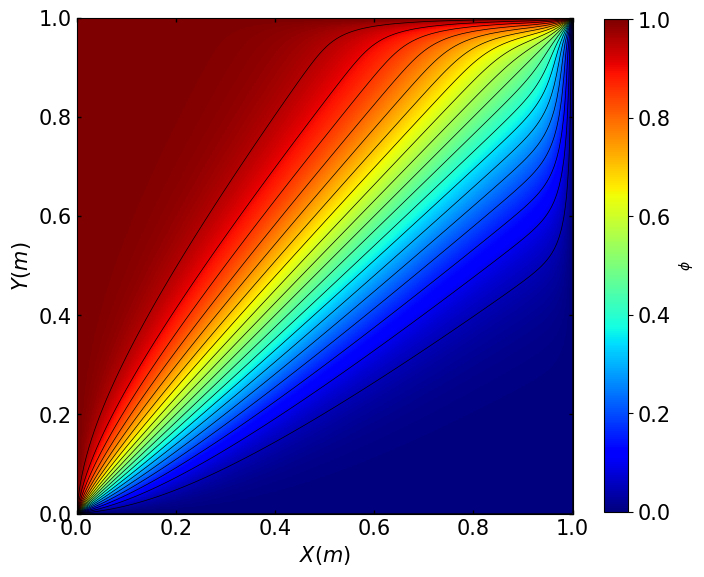

In [154]:
# Figure specifications
fontsize=15

# Start first plot
plt.figure(1)
plt.figure(figsize = (8,8))
plt.tick_params(axis='both', which='both',length=3, width=1.0,
labelsize=15, right=True, top=True, direction='in') # For ticks in borders

# Figure labels
plt.xlabel(r"$X(m)$", fontsize=fontsize)
plt.ylabel(r"$Y(m)$", fontsize=fontsize)

# Plot
plt.contour(X_P, Y_P, phi, levels=20, colors='black', linewidths=0.5)
plt.imshow(phi, cmap= 'jet', extent=(X_P.min(), X_P.max(), Y_P.min(), Y_P.max()), origin='lower')
plt.colorbar( label = r"$\phi$", shrink = 0.8 ).ax.tick_params( labelsize =15)

plt.show(1)
